In [201]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from torchvision import transforms
import math
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from statistics import mean, median, mode
from IPython.display import FileLink
import gc
import random
from PIL import Image, ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset
from tqdm import tqdm

In [202]:
def load_image(image_path, w_max, gamma, hardcoded_range):
    img = load_image_from_path(image_path)
    hd1, hd2 = hardcoded_range
    hardcoded_img = img[hd1: hd2]
    img, (w, h), (wf, hf) = preprocess(img, w_max, gamma)
    hardcoded_img, (_, _), (_, _) = preprocess(hardcoded_img, w_max, gamma)
    wr, hr = wf/w, hf/h
    return img, hardcoded_img, (wf, hf), (wr, hr)

def thresholding(image, threshold):
    # grayscaling the image
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # all pixels below threshold will turn black and rest will become 255
    _, thresh_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return thresh_img


def dilate(thresh_img, kernel_dims):
    kernel = np.ones(kernel_dims, np.uint8)
    dilated_img = cv2.dilate(thresh_img, kernel, iterations = 1)
    return dilated_img


In [203]:
image_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
tensor_to_img_transform = transforms.ToPILImage()

def return_tensor(image):
    image = fromarray(image)
    return image_transform(image)

In [204]:
GAMMA = 2
W_MAX = 1000
THRESHOLD = 40
KERNEL_DIMS = (85,85)
HARDCODED_RANGE = (710,2800)
LINE_KERNEL_DIMS = (20,800)
WORD_KERNEL_DIMS = (12,12)

In [205]:
def tensor_to_cvarray(img_tensor):
    img = tensor_to_img_transform(img_tensor)
    cv_img = np.array(img)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    return cv_img

In [206]:
def convert_to_tensor(image, w=None, h=None):
    image = fromarray(image)
    if w and h:
        image = transforms.Compose([transforms.Resize((h,w)), transforms.Grayscale(), transforms.ToTensor()])(image)
    else:
        image =  transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])(image)
    return image

In [207]:
def plot_tensor(img, axis='off'):
    plt.imshow(img.permute(1,2,0), cmap='gray')
    if axis == 'off':
        plt.axis('off')
    plt.show()

In [208]:
def generate_line_images(img_tensor, w_max, gamma, threshold, kernel_dims, num_lines_threshold=4):
    img = tensor_to_cvarray(img_tensor)
    img, _, _ = preprocess(img, w_max, gamma)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    lines_images = []

    wl = []
    hl = []
    
    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        if w >= 100 and h >= 20 and area>=10000:
            wl.append(w)
            hl.append(h)
            lines_images.append(img[y:y+h, x:x+w])
            
    if len(lines_images) <= num_lines_threshold:
        lines_images = []
    
    hmedian = median(hl)
    
    lines_tensor_list = []
    for each in range(len(lines_images)):
        himg = hl[each]
        if himg > 0.5*hmedian:
            if himg <+ 1.5*hmedian:
                lines_tensor_list.append(convert_to_tensor(lines_images[each]))
            else:
                limg1 = lines_images[each][:himg//2]
                limg2 = lines_images[each][himg//2:]
                lines_tensor_list.append(convert_to_tensor(limg1))
                lines_tensor_list.append(convert_to_tensor(limg2))
    
    return lines_tensor_list

In [209]:
# cropped_images = torch.load('/kaggle/input/iam-forms-cropped-images/cropped_images.pt')

# hlist = []
# wlist = []

# for each in range(len(cropped_images)):
#     print(f'{each+1}/{len(cropped_images)}')
#     l = generate_line_images(cropped_images[each], W_MAX, GAMMA, THRESHOLD, LINE_KERNEL_DIMS)
#     for each in l:
#         c,h,w = each.shape
#         hlist.append(h)
#         wlist.append(w)

In [210]:
# mean(wlist), median(wlist), mode(wlist), min(wlist), max(wlist)

In [211]:
# mean(hlist), median(hlist), mode(hlist), min(hlist), max(hlist)

In [212]:
def generate_word_images(img_tensor, threshold, kernel_dims):
    img = tensor_to_cvarray(img_tensor)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    words_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        words_images.append([img[y:y+h, x:x+w], x, y, w, h])
    
    words_images.sort(key=lambda x: x[1])

    words_tensor_list = []
    for each, x, y, w, h in words_images:
        words_tensor_list.append([convert_to_tensor(each), [x,y,w,h]])

    return words_tensor_list

In [213]:
def generate_lines_and_bboxes(img_tensor):
    lt = generate_line_images(img_tensor, THRESHOLD, LINE_KERNEL_DIMS)
    line_lists = []
    bb_list = []
    for lidx in range(len(lt)):
        words = generate_word_images(lt[lidx], THRESHOLD, WORD_KERNEL_DIMS)
        limg = tensor_to_cvarray(lt[lidx])
        linew, lineh, c = limg.shape
        bbox = []
        for each in words:
            x,y,w,h = each[1]
            x = math.ceil(x*1000/lineh)
            w = math.ceil(w*1000/lineh)
            y = math.ceil(y*80/linew)
            h = math.ceil(h*80/linew)
            bbox.append([x, y, x+w, y+h])
        
        line_lists.append(convert_to_tensor(limg, 1000, 80))
        bb_list.append(bbox)
    
    return line_lists, bb_list

In [214]:
# ll_final = []
# bb_final = []

# total_images = len(cropped_images)

# for each in range(total_images):
#     print(f'generating bounding boxes for image {each+1}/{total_images}')
#     ll, bb = generate_lines_and_bboxes(cropped_images[each])
#     ll_final.extend(ll)
#     bb_final.extend(bb)

# torch.save(ll_final, 'line_images.pt')
# torch.save(bb_final, 'line_bboxes.pt')

In [215]:
ll_final = torch.load('/kaggle/input/iam-line-images-and-bboxes/line_images.pt')
bb_final = torch.load('/kaggle/input/iam-line-images-and-bboxes/line_bboxes.pt')

In [216]:
len(ll_final)

10115

In [217]:
ll_final[0].shape

torch.Size([1, 80, 1000])

In [218]:
class BBoxDataset(Dataset):
    def __init__(self, lines_list, bb_list):
        self.lines_list = lines_list
        self.bb_list = bb_list
    
    def __len__(self):
        return len(self.lines_list)
    
    def __getitem__(self, idx):
        img = self.lines_list[idx]
        boxes = self.bb_list[idx]
        labels = torch.ones((len(boxes)), dtype=torch.int64)
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["label"] = labels
        return img, target

In [219]:
db = BBoxDataset(ll_final[:100], bb_final[:100])
resu1t_bbox = bb_final[130]
dataloader = DataLoader(db, batch_size=32, collate_fn=lambda x:x, shuffle=True,
                        pin_memory=True if torch.cuda.is_available() else False)

for data in dataloader:
    print(data[0][0].shape)
    print(data[0][1])
    break

torch.Size([1, 80, 1000])
{'boxes': tensor([[ 46,   4, 175,  71],
        [192,  14, 377,  74],
        [396,  30, 482,  78],
        [496,   7, 565,  56],
        [571,  28, 656,  58],
        [659,   4, 761,  67],
        [697,  15, 710,  27],
        [761,   5, 854,  56],
        [858,  14, 907,  55]]), 'label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])}


In [220]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print(device)

cpu


In [221]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True).to(device)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [222]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

In [223]:
# training loop
'''
for epochs in range(num_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    epoch_loss = 0
    for data in tqdm(dataloader):
        imgs = []
        targets = []
        for d in tqdm(data):
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]['boxes'].to(device)
            targ["labels"] = d[1]['label'].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss)
'''
pass

In [224]:
# torch.save(model.state_dict(), 'line_to_word_model.pth')

In [225]:
model.load_state_dict(torch.load('/kaggle/input/d/tanishpagaria/line-to-word-model/line_to_word_model.pth'))

<All keys matched successfully>

In [226]:
test_img = ll_final[130]
test_bbox = bb_final[130]
model.eval()
res = model([test_img.to(device)])

In [227]:
result_bbox = res[0]['boxes']
result_scores = res[0]['scores']
test_img = tensor_to_cvarray(test_img)

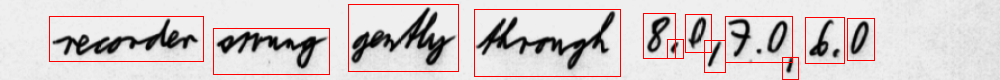

In [228]:
vsample = Image.fromarray(test_img)
draw = ImageDraw.Draw(vsample)
for box in resu1t_bbox:
    draw.rectangle(list(box), fill=None, outline='red')
vsample

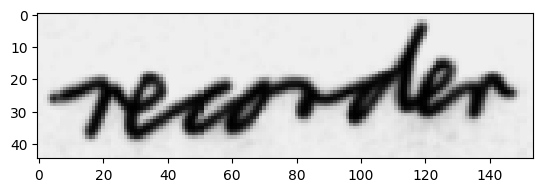

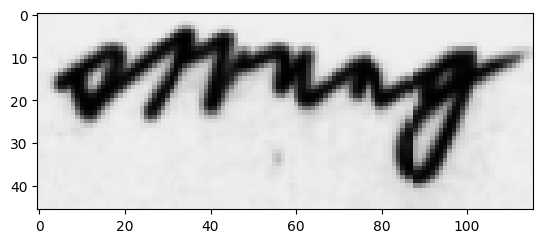

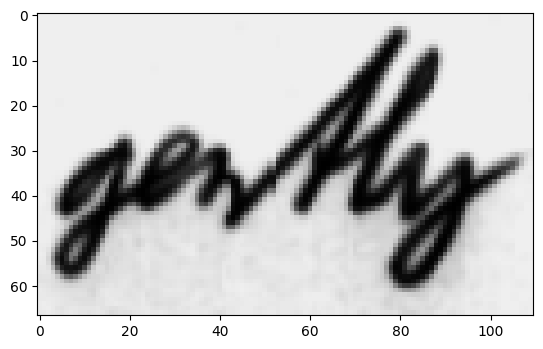

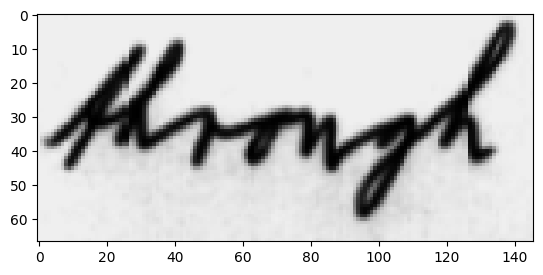

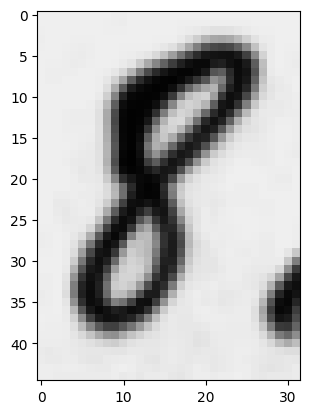

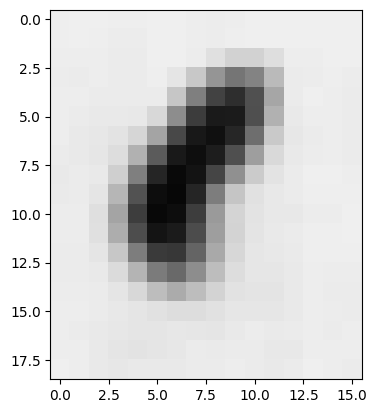

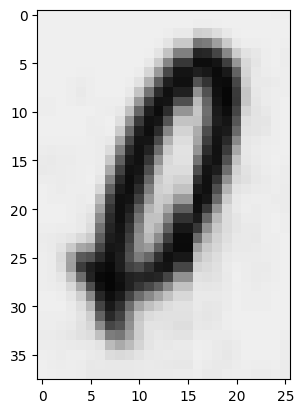

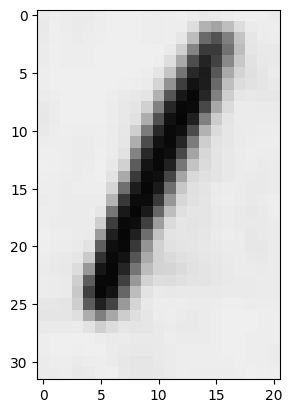

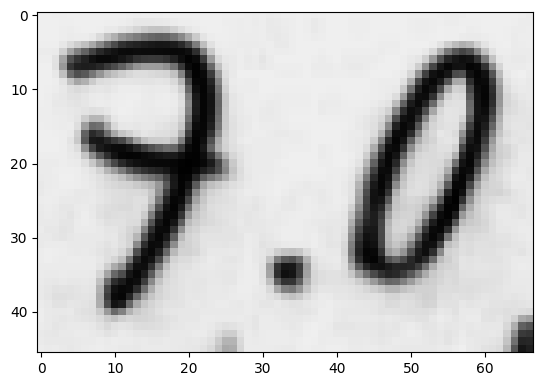

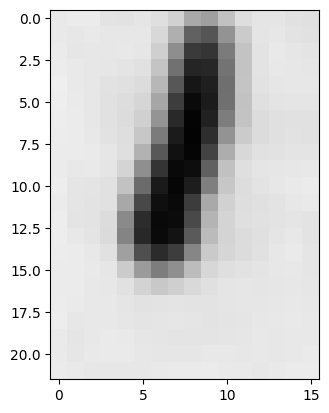

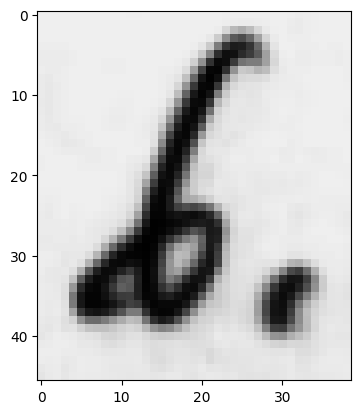

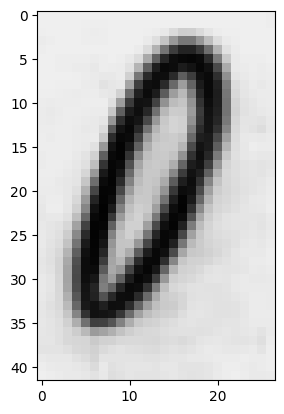

In [229]:
for box in resu1t_bbox:
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    plt.imshow(test_img[y1:y2, x1:x2])
    plt.show()